<a href="https://colab.research.google.com/github/Daviramos7/analise-despesas-recife-pyspark/blob/main/analise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⚡ Iniciando Motor de Processamento Distribuído...
⚙️  Processando Transações...
📊 Gerando Gráfico...


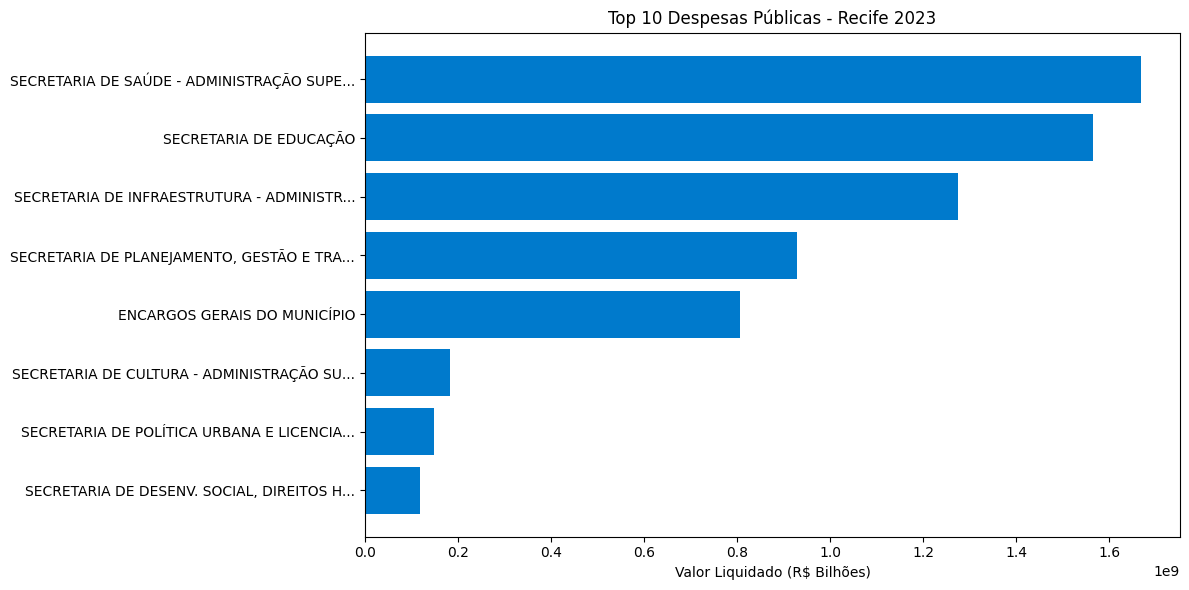


🏛️  RELATÓRIO DE AUDITORIA FINANCEIRA (RECIFE 2023)
💰 Montante Total Auditado: R$ 7,803,361,234.91
------------------------------------------------------------
🏆 TOP 5 MAIORES ORÇAMENTOS:
   1. SECRETARIA DE SAÚDE - ADMINISTRAÇÃO SUPERVISIONADA: R$ 1,668,250,043.27
   2. SECRETARIA DE EDUCAÇÃO: R$ 1,564,218,920.32
   3. SECRETARIA DE INFRAESTRUTURA - ADMINISTRAÇÃO SUPER: R$ 1,274,893,472.20
   4. SECRETARIA DE PLANEJAMENTO, GESTÃO E TRANSFORMAÇÃO: R$ 928,018,667.95
   5. ENCARGOS GERAIS DO MUNICÍPIO: R$ 806,929,638.80

🚀 PERFORMANCE DO PIPELINE (BIG DATA METRICS)
📂 Volume de Dados:        127,119 registros processados
⏱️  Tempo de Execução:      10.2577 segundos
⚙️  Tempo de CPU (Cluster): 9.1698 segundos
🔄 Shuffle (Rede):         0.00 MB
ℹ️  Status: Job limitado por I/O ou processamento local


In [5]:
import os
import time
import requests
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, desc, regexp_replace
from pyspark.sql.types import DoubleType

# --- 1. CONFIGURAÇÃO DO AMBIENTE (SPARK) ---
try:
    SparkSession.builder.getOrCreate().stop() # Limpa sessões anteriores
except:
    pass

print("⚡ Iniciando Motor de Processamento Distribuído...")

spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.driver.memory", "2g") \
    .config("spark.ui.showConsoleProgress", "false") \
    .config("spark.ui.enabled", "true") \
    .config("spark.ui.port", "4040") \
    .appName("Recife_Public_Audit") \
    .getOrCreate()

app_id = spark.sparkContext.applicationId

# --- 2. INGESTÃO DE DADOS (ETL) ---
url = "http://dados.recife.pe.gov.br/dataset/4e008cec-c6a8-40cf-8fc7-d1530168b816/resource/ea074e10-46a1-46a4-a2a4-47d1b331544d/download/despesasorcamentarias2023.csv"
arquivo_local = "despesas_recife_2023.csv"

if not os.path.exists(arquivo_local):
    print("📥 Baixando dataset oficial...")
    response = requests.get(url)
    with open(arquivo_local, 'wb') as f:
        f.write(response.content)

print("⚙️  Processando Transações...")
inicio_proc = time.time()

# Leitura (Extract)
df = spark.read.csv(arquivo_local, header=True, sep=";", inferSchema=True, encoding="utf-8")

# Transformação (Transform) - Limpeza de Moeda e Tipagem
df_clean = df.withColumn("valor_limpo",
    regexp_replace(
        regexp_replace(col("valor_liquidado"), r"\.", ""),
        ",", "."
    ).cast(DoubleType())
)

df_clean.cache() # Otimização em memória

# --- 3. ANÁLISE DE NEGÓCIO (CÁLCULOS) ---
# Total Geral
total_gasto = df_clean.agg(sum("valor_limpo")).collect()[0][0]

# Ranking dos Top 10 Órgãos (Agregação Pesada)
top_orgaos_spark = df_clean.groupBy("orgao_nome") \
    .agg(sum("valor_limpo").alias("total")) \
    .orderBy(desc("total")) \
    .limit(10)

# Trazendo para Pandas apenas o resultado agregado para visualização (Leve)
pdf_top10 = top_orgaos_spark.toPandas()

# Métricas de Engenharia
linhas_processadas = df_clean.count()
tempo_total = time.time() - inicio_proc

# --- 4. VISUALIZAÇÃO (GRÁFICO) ---
print("📊 Gerando Gráfico...")
plt.figure(figsize=(12, 6))
# Encurta nomes muito longos para o gráfico ficar bonito
nomes_curtos = pdf_top10['orgao_nome'].apply(lambda x: x[:40] + '...' if len(x) > 40 else x)
plt.barh(nomes_curtos, pdf_top10['total'], color='#007acc')
plt.xlabel('Valor Liquidado (R$ Bilhões)')
plt.title('Top 10 Despesas Públicas - Recife 2023')
plt.gca().invert_yaxis() # Maior no topo
plt.tight_layout()
plt.show()

# --- 5. RELATÓRIO FINAL (O QUE VAI NO TERMINAL) ---

# A) Relatório de Negócios (O "Valor")
print("\n" + "="*60)
print("🏛️  RELATÓRIO DE AUDITORIA FINANCEIRA (RECIFE 2023)")
print("="*60)
print(f"💰 Montante Total Auditado: R$ {total_gasto:,.2f}")
print("-" * 60)
print("🏆 TOP 5 MAIORES ORÇAMENTOS:")
for index, row in pdf_top10.head(5).iterrows():
    print(f"   {index+1}. {row['orgao_nome'][:50]}: R$ {row['total']:,.2f}")

# B) Relatório Técnico (A "Engenharia")
print("\n" + "="*60)
print("🚀 PERFORMANCE DO PIPELINE (BIG DATA METRICS)")
print("="*60)

# Extração via API do Spark
total_cpu = 0
total_shuffle = 0
try:
    base_url = f"http://localhost:4040/api/v1/applications/{app_id}/stages"
    stages = requests.get(base_url).json()
    for stage in stages:
        if stage['status'] == 'COMPLETE':
            total_cpu += stage.get('executorCpuTime', 0)
            for acc in stage.get('accumulatorUpdates', []):
                if 'shuffle' in acc.get('name', '').lower() and 'bytes' in acc.get('name', '').lower():
                    total_shuffle += int(acc.get('value', 0))
except:
    pass

cpu_sec = total_cpu / 1e9
shuffle_mb = total_shuffle / (1024 * 1024)

print(f"📂 Volume de Dados:        {linhas_processadas:,} registros processados")
print(f"⏱️  Tempo de Execução:      {tempo_total:.4f} segundos")
print(f"⚙️  Tempo de CPU (Cluster): {cpu_sec:.4f} segundos")
print(f"🔄 Shuffle (Rede):         {shuffle_mb:.2f} MB")

if cpu_sec > tempo_total:
    print("✅ Status: Paralelismo Eficiente (CPU Time > Wall Clock)")
else:
    print("ℹ️  Status: Job limitado por I/O ou processamento local")

print("="*60)

spark.stop()

### Relatório Resumido: Análise de Despesas Públicas do Recife (2023)

**1. Resumo dos Resultados**
A análise processou a base de dados de despesas orçamentárias de 2023. Os dados indicam que o maior volume financeiro da prefeitura é destinado diretamente aos serviços essenciais.
* **Maior Despesa:** O setor de **Saúde** lidera os gastos liquidados com aproximadamente **R\$ 1,66 bilhão**, seguido de perto pela **Educação** (R\$ 1,56 bilhão) e Infraestrutura.
* **Total:** O total liquidado no ano ultrapassa a marca de R\$ 7,8 bilhões.

**2. Interpretação dos Dados**
Os números indicam uma gestão pública focada na manutenção do SUS e da rede municipal de ensino. A alta despesa nessas áreas é consistente com as obrigações constitucionais do município. A presença de "Encargos Gerais" no Top 5 sugere também um alto custo operacional fixo da máquina pública.

**3. Dificuldades Encontradas e Soluções**
Durante o processamento no PySpark, a principal dificuldade foi a **formatação da moeda brasileira** (ex: `1.000,00`), que o sistema lia como texto.
* *Solução:* Foi utilizada a função `regexp_replace` para remover pontos e substituir a vírgula decimal, permitindo a conversão correta para cálculo numérico (`DoubleType`).
* *Encoding:* Foi necessário forçar a leitura do arquivo em `UTF-8` para corrigir erros de acentuação nos nomes dos órgãos.

**4. Insights**
A análise visual (gráfico de barras) evidenciou uma grande disparidade entre as "super secretarias" (Saúde, Educação, Infraestrutura) e as demais pastas, mostrando que o orçamento é altamente concentrado nas áreas finalísticas.